<a href="https://colab.research.google.com/github/tatiana-iazykova/2020_HACK_RUSSIANSUPERGLUE/blob/main/RSG_LiDiRus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/ru/tasks/download/LiDiRus" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip
rm -r data/__MACOSX
rm -r sample_data/

# AX-b original English diagnostic dataset
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://dl.fbaipublicfiles.com/glue/superglue/data/v2/AX-b.zip" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip

# RSG TERRA dataset -> only to reproduce TfIdf baseline
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/tasks/download/TERRa" -O temp.zip
unzip temp.zip -d data
rm -r data/__MACOSX

# remove unnecessary directories and files
rm temp.zip

In [2]:
# Load necessary code files and models from https://github.com/RussianNLP/RussianSuperGLUE 
# to recreate TfIdf baseline

%%capture
%%bash
# load tfidf pickle created by RSG team
wget -q --show-progress "https://russiansuperglue.com/tasks/tf_idf" -O temp.zip
unzip temp.zip -d data
rm temp.zip

# Make sure you donwload with the raw file link
# Keep the link relevant to your dataset
wget -q --show-progress "https://github.com/RussianNLP/RussianSuperGLUE/raw/master/tfidf_baseline/LiDiRus.py" -O LiDiRus.py

# Load modules to solve this dataset tasks
wget -q --show-progress "https://github.com/tatiana-iazykova/2020_HACK_RUSSIANSUPERGLUE/raw/main/base.py" -O base.py
wget -q --show-progress "https://github.com/tatiana-iazykova/2020_HACK_RUSSIANSUPERGLUE/raw/main/utils.py" -O utils.py
wget -q --show-progress "https://github.com/tatiana-iazykova/2020_HACK_RUSSIANSUPERGLUE/raw/main/Solvers/LiDiRusSolver.py" -O LiDiRusSolver.py

In [3]:
%%capture
%%bash
# add tree package for fancy directory display
apt-get install tree

In [4]:
# display the content of the folder
!tree

.
├── base.py
├── data
│   ├── AX-b
│   │   └── AX-b.jsonl
│   ├── LiDiRus
│   │   └── LiDiRus.jsonl
│   ├── TERRa
│   │   ├── test.jsonl
│   │   ├── train.jsonl
│   │   └── val.jsonl
│   └── tfidf.pkl
├── LiDiRus.py
├── LiDiRusSolver.py
└── utils.py

4 directories, 10 files


# **Solving LiDiRus with heuristics**

In [5]:
%%capture
# to lemmantize, install these two dependancies
!pip3 install pyMorphy2[fast]
!pip3 install razdel

In [18]:
import numpy as np
from LiDiRusSolver import LiDiRusSolver
from base import seed_everything
from sklearn.metrics import matthews_corrcoef

solver = LiDiRusSolver(path='data/LiDiRus/LiDiRus.jsonl',
                       path_valid='data/LiDiRus/LiDiRus.jsonl')
solver.preprocess()

SEEDS = [42, 23, 1234567]

## **All heursitics at once**

In [26]:
y_true, y_pred = solver.heuristics(final_decision=solver.majority_class)
print(f"All heuristics + Majority class")
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")

Heuristics appears for 743 samples, 480 of them correct
All heuristics + Majority class
MC score is 0.1468301818966266


In [32]:
metrics = []
for seed in SEEDS:
    y_true, y_pred = solver.heuristics(final_decision=solver.random_choice)
    metrics.append(matthews_corrcoef(y_true, y_pred))
print(f'All heuristics + Random choice')
print(f"Average MC score over {len(SEEDS)} experiments: {np.array(metrics).mean()}")

Heuristics appears for 743 samples, 480 of them correct
Heuristics appears for 743 samples, 480 of them correct
Heuristics appears for 743 samples, 480 of them correct
All heuristics + Random choice
Average MC score over 3 experiments: 0.16028549237965636


In [35]:
metrics = []
for seed in SEEDS:
    y_true, y_pred = solver.heuristics(final_decision=solver.random_balanced_choice)
    metrics.append(matthews_corrcoef(y_true, y_pred))
print(f'All heuristics + Random balanced choice')
print(f"Average MC score over {len(SEEDS)} experiments: {np.array(metrics).mean()}")

Heuristics appears for 743 samples, 480 of them correct
Heuristics appears for 743 samples, 480 of them correct
Heuristics appears for 743 samples, 480 of them correct
All heuristics + Random balanced choice
Average MC score over 3 experiments: 0.15619853885506021


## **Solving with a single heuristic only**

### Presence of certain words

These words lead to **not_etailment**:
{'и', "не", "никогда", "вовсе", 'что', "это"}

In [37]:
print('wordlist + Majority class')
y_true, y_pred = solver.heuristics(final_decision=solver.majority_class,
                                   heuristic = {"not_entailment": "wordlist"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('wordlist + Random choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_choice,
                                   heuristic = {"not_entailment": "wordlist"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('wordlist + Random balanced choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_balanced_choice,
                                   heuristic = {"not_entailment": "wordlist"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")

wordlist + Majority class
Heuristics appears for 324 samples, 215 of them correct
MC score is 0.0


wordlist + Random choice


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Heuristics appears for 324 samples, 215 of them correct
MC score is 0.06105850725690931


wordlist + Random balanced choice
Heuristics appears for 324 samples, 215 of them correct
MC score is 0.030518602656269548


These words lead to **etailment**: {"чтобы", 'будет', "от", "он"}

In [38]:
print('wordlist + Majority class')
y_true, y_pred = solver.heuristics(final_decision=solver.majority_class,
                                   heuristic = {"entailment": "wordlist"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('wordlist + Random choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_choice,
                                   heuristic = {"entailment": "wordlist"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('wordlist + Random balanced choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_balanced_choice,
                                   heuristic = {"entailment": "wordlist"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")

wordlist + Majority class
Heuristics appears for 128 samples, 73 of them correct
MC score is 0.1135629172396206


wordlist + Random choice
Heuristics appears for 128 samples, 73 of them correct
MC score is 0.03115998708469565


wordlist + Random balanced choice
Heuristics appears for 128 samples, 73 of them correct
MC score is 0.05480158001362251


### Sentences 1 and 2 have one unique word *each*

This heuristic catches the following pairs:
*   I love RSG tasks. VS I like RSG tasks. [like, love]

**NB**: The sentences of this type are also caught as TRUE:


*   I like RSG tasks. VS I really like these RSG tasks. ["really", "these"]






In [39]:
print('keyword + Majority class')
y_true, y_pred = solver.heuristics(final_decision=solver.majority_class,
                                   heuristic = {"not_entailment": "keyword"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('keyword + Random choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_choice,
                                   heuristic = {"not_entailment": "keyword"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('keyword + Random balanced choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_balanced_choice,
                                   heuristic = {"not_entailment": "keyword"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")

keyword + Majority class
Heuristics appears for 177 samples, 118 of them correct
MC score is 0.0


keyword + Random choice


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Heuristics appears for 177 samples, 118 of them correct
MC score is 0.023044474797014863


keyword + Random balanced choice
Heuristics appears for 177 samples, 118 of them correct
MC score is 0.07184652446326294


### Too many non-intersecting words between sentence 1 and 2 

In [40]:
print('little overlap + Majority class')
y_true, y_pred = solver.heuristics(final_decision=solver.majority_class,
                                   heuristic = {"not_entailment": "little overlap"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('little overlap + Random choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_choice,
                                   heuristic = {"not_entailment": "little overlap"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('little overlap + Random balanced choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_balanced_choice,
                                   heuristic = {"not_entailment": "little overlap"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")

little overlap + Majority class
Heuristics appears for 268 samples, 175 of them correct
MC score is 0.0


little overlap + Random choice


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Heuristics appears for 268 samples, 175 of them correct
MC score is 0.06603497698252156


little overlap + Random balanced choice
Heuristics appears for 268 samples, 175 of them correct
MC score is 0.08699220515984948


### Extra clause in one of the sentences

This heuristic triggers when there are two extra commas in one of the sentences


In [41]:
print('extra clause + Majority class')
y_true, y_pred = solver.heuristics(final_decision=solver.majority_class,
                                   heuristic = {"not_entailment": "extra clause"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('extra clause + Random choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_choice,
                                   heuristic = {"not_entailment": "extra clause"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('extra clause + Random balanced choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_balanced_choice,
                                   heuristic = {"not_entailment": "extra clause"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")

extra clause + Majority class
Heuristics appears for 301 samples, 193 of them correct
MC score is 0.0


extra clause + Random choice


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Heuristics appears for 301 samples, 193 of them correct
MC score is 0.02751247973751072


extra clause + Random balanced choice
Heuristics appears for 301 samples, 193 of them correct
MC score is 0.08153204830622662


### All Lemmas in sentences 1 and 2 overlap

In [42]:
print('All lemmas overlap + Majority class')
y_true, y_pred = solver.heuristics(final_decision=solver.majority_class,
                                   heuristic = {"entailment": "all lemmas overlap"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('All lemmas overlap + Random choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_choice,
                                   heuristic = {"entailment": "all lemmas overlap"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")
print('\n')
print('All lemmas overlap + Random balanced choice')
y_true, y_pred = solver.heuristics(final_decision=solver.random_balanced_choice,
                                   heuristic = {"entailment": "all lemmas overlap"})
print(f"MC score is {matthews_corrcoef(y_true, y_pred)}")

All lemmas overlap + Majority class
Heuristics appears for 45 samples, 29 of them correct
MC score is 0.09564805053434217


All lemmas overlap + Random choice
Heuristics appears for 45 samples, 29 of them correct
MC score is 0.0621714403614308


All lemmas overlap + Random balanced choice
Heuristics appears for 45 samples, 29 of them correct
MC score is 0.013045717448494962


# Reproduce TfIdf baseline

In [ ]:
import pickle
import codecs
import joblib
import LiDiRus

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

vect = joblib.load("data/tfidf.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
# Note that train and val datasets are not from LiDiRus as it is a diagnostics dataset
train_path = "data/TERRa/train.jsonl"
val_path = "data/TERRa/val.jsonl"
test_path = "data/LiDiRus/LiDiRus.jsonl"

_, LiDiRus_scores = LiDiRus.eval_LiDiRus(train_path, val_path, test_path, vect)
LiDiRus_scores["test"]

0.05974021843803689

# Explore Ru and Eng dataset

Russian is a manual translation of an English diagnistic dataset
https://russiansuperglue.com/tasks/task_info/LiDiRus

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 20)

class JSONL_handler():
    """ opens a jsonl file and turns it into a necessary data structure """
    
    def __init__(self, path):
        self.path = path # path to jsonl file

    def to_pandas(self):
        """ get jsonl file content as a pandas DataFrame"""
        return pd.read_json(path_or_buf=self.path, lines=True)

In [ ]:
handler = JSONL_handler('data/LiDiRus/LiDiRus.jsonl')
df = handler.to_pandas()
handler_en = JSONL_handler('data/AX-b/AX-b.jsonl')
df_en = handler.to_pandas()

In [ ]:
import matplotlib.pyplot as plt

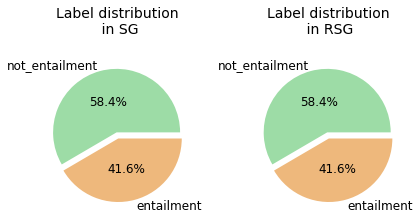

In [ ]:
plt.subplot(1,2,1)
colours = {'#9ddca6', '#f0afb6', '#eeb87c'}

plt.title('Label distribution\n in SG\n', fontsize=14)
plt.pie(df_en['label'].value_counts(), autopct="%.1f%%", explode=[0.05]*2, labels=df_en['label'].value_counts().keys(), pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)

plt.subplot(1,2,2)

plt.title('Label distribution\n in RSG\n', fontsize=14)
plt.pie(df['label'].value_counts(), autopct="%.1f%%", explode=[0.05]*2, labels=df['label'].value_counts().keys(), pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)

plt.tight_layout()
plt.show()

# Feature analysis

In [ ]:
%%capture
!pip install eli5

In [ ]:
import numpy as np
import eli5
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef

In [ ]:
vectorizer = TfidfVectorizer()
clf = SGDClassifier(loss="log", n_jobs=-1, alpha=0.15, class_weight='balanced', random_state=42)

df = df.assign(merged=lambda x: x.sentence1 + "\n" + x.sentence2)

train_texts, test_texts, train_labels, test_labels = train_test_split(df.merged,
                                                                      df.label,
                                                                      test_size=0.1,
                                                                      shuffle=True)


X = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts) 

y = np.array(train_labels)
y_test = np.array(test_labels)

clf.fit(X, y)
preds = clf.predict(X_test)

matthews_corrcoef(y_test, preds)

0.16313260212626532

In [ ]:
eli5.show_weights(clf, top=25, feature_names=vectorizer.get_feature_names())

Weight?,Feature
+0.015,не
+0.013,гришэм
+0.013,народное
+0.013,голосование
+0.013,что
+0.009,нет
+0.009,лечения
+0.009,успех
+0.009,ответственности
+0.009,выиграл


# Explore LiDiRus Dataset

In [ ]:
pd.merge(df.logic.value_counts(), df_en.logic.value_counts(), how='left', on=df_en.logic.value_counts().keys())

,key_0,logic_x,logic_y
0,Negation,54,54
1,Intervals/Numbers,30,30
2,Upward monotone,30,30
3,Temporal,28,28
4,Downward monotone,26,26
...,...,...,...
24,Universal;Negation,2,2
25,Temporal;Conjunction,2,2
26,Temporal;Intervals/Numbers,2,2
27,Downward monotone;Conditionals,2,2


In [ ]:
df.columns

Index(['idx', 'label', 'sentence1', 'sentence2', 'logic',
       'predicate-argument-structure', 'lexical-semantics', 'knowledge'],
      dtype='object')

In [ ]:
df['knowledge'].value_counts()

Common sense       150
World knowledge    134
Name: knowledge, dtype: int64

In [ ]:
df['predicate-argument-structure'].value_counts()

Prepositional phrases                    56
Core args                                48
Intersectivity                           44
Anaphora/Coreference                     42
Coordination scope                       34
                                         ..
Intersectivity;Ellipsis/Implicits         2
Nominalization;Genitives/Partitives       2
Relative clauses;Anaphora/Coreference     2
Restrictivity;Anaphora/Coreference        2
Active/Passive;Prepositional phrases      2
Name: predicate-argument-structure, Length: 23, dtype: int64

In [ ]:
df['lexical-semantics'].value_counts()

Lexical entailment                134
Factivity                          64
Quantifiers                        46
Named entities                     36
Symmetry/Collectivity              28
Morphological negation             26
Redundancy                         25
Lexical entailment;Quantifiers      4
Lexical entailment;Factivity        2
Factivity;Quantifiers               2
Name: lexical-semantics, dtype: int64

### Description 

There are small batches of sentences with slightly varying vocabulary

In [ ]:
df.iloc[[0,1,4,5,6,7]][['label', 'sentence1', 'sentence2', 'logic']]

,label,sentence1,sentence2,logic
0,not_entailment,Кошка сидела на коврике.,Кошка не сидела на коврике.,Negation
1,not_entailment,Кошка не сидела на коврике.,Кошка сидела на коврике.,Negation
4,not_entailment,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.","Сразу же после распаковки Ouya не поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.",Negation
5,not_entailment,"Сразу же после распаковки Ouya не поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.","Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.",Negation
6,entailment,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,NaN
7,entailment,Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",NaN


# Intermediary conslusions (being updated)

### Entailment indicators:

 - presence of certain words among non intersecting tokens **{"чтобы", 'будет', "от", "он"}**
 - All lemmas of sentence 1 and 2 intersect

### Not-entailment indicators:
 - presentence of certain words among non intersecting tokens **{'и', "не", "никогда", "вовсе", 'что', "это"}**
 - Non intersecting words == 2
 - Little overlap between sentences 
 - Extra clause within the sentence



## **Entailment**

In [ ]:
df[df.label == 'entailment'][['sentence1', 'sentence2']][0:20]

,sentence1,sentence2
6,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.
7,Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер."
18,"Применяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.","Применяя стратегию протеста, Ганди застал администрацию врасплох и получил уступки от властей."
22,Написание кода на Java не слишком отличается от программирования в наручниках.,Написание кода на Java подобно программированию в наручниках.
23,Написание кода на Java подобно программированию в наручниках.,Написание кода на Java не слишком отличается от программирования в наручниках.
24,"Рынок станет сложнее, но на нём не будет невозможно ориентироваться.","Рынок станет сложнее, но на нём будет возможно ориентироваться."
25,"Рынок станет сложнее, но на нём будет возможно ориентироваться.","Рынок станет сложнее, но на нём не будет невозможно ориентироваться."
26,"Даже после того как узнал, что это корм для животных, я не перестану когда-либо обожать Flamin' Hot Cheetos.","Даже после того как узнал, что это корм для животных, я никогда не перестану обожать Flamin' Hot Cheetos."
27,"Даже после того как узнал, что это корм для животных, я никогда не перестану обожать Flamin' Hot Cheetos.","Даже после того как узнал, что это корм для животных, я не перестану когда-либо обожать Flamin' Hot Cheetos."
28,"Он не был несогласен с позицией партии, но чувствовал, что если бы он ушел в отставку, его популярность среди индейцев перестала бы душить членство в партии.","Он согласился с позицией партии, но чувствовал, что если бы он ушел в отставку, его популярность среди индейцев перестала бы душить членство в партии."


### Vocabulary overlap

In [ ]:
df.iloc[[6,7,18,32,33,56,63,72,74,75,77,80,81,82,83,84,85,144,145]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
6,6,entailment,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,NaN,Anaphora/Coreference,NaN,NaN
7,7,entailment,Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",NaN,Anaphora/Coreference,NaN,NaN
18,18,entailment,"Применяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.","Применяя стратегию протеста, Ганди застал администрацию врасплох и получил уступки от властей.",NaN,Intersectivity,NaN,NaN
32,32,entailment,"Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна ожидаемо.","Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, ожидаемо негативное влияние на результаты пайплайна.",NaN,Nominalization,NaN,NaN
33,33,entailment,"Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, ожидаемо негативное влияние на результаты пайплайна.","Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна ожидаемо.",NaN,Nominalization,NaN,NaN
56,56,entailment,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим некоторые слова как положительные примеры – и несколько негативных наугад из словаря.,Upward monotone,Intersectivity,NaN,NaN
63,63,entailment,Рассмотрим все слова как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим все слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Downward monotone,Intersectivity,NaN,NaN
72,72,entailment,"На всех территориях деятельность человека изменила форму русла рек, влияя на масштаб и частоту наводнений.","На всех развитых территориях деятельность человека изменила форму русла рек, влияя на масштаб и частоту наводнений.",Downward monotone,Intersectivity,NaN,NaN
74,74,entailment,Том и Адам шептались в театре.,Том и Адам тихо шептались в театре.,NaN,NaN,Redundancy,NaN
75,75,entailment,Том и Адам тихо шептались в театре.,Том и Адам шептались в театре.,NaN,NaN,Redundancy,NaN


###  other, including active/passive which will be close to overlapping after lemmantizing

In [ ]:
df.iloc[[22,23,44,45,48,51,52,54,61,65,66,78,79,86,87,90,91,94,95,108,109,142,143, 149, 150]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge,merged
22,22,entailment,Написание кода на Java не слишком отличается от программирования в наручниках.,Написание кода на Java подобно программированию в наручниках.,Double negation,NaN,Morphological negation,NaN,Написание кода на Java не слишком отличается от программирования в наручниках.\nНаписание кода на Java подобно программированию в наручниках.
23,23,entailment,Написание кода на Java подобно программированию в наручниках.,Написание кода на Java не слишком отличается от программирования в наручниках.,Double negation,NaN,Morphological negation,NaN,Написание кода на Java подобно программированию в наручниках.\nНаписание кода на Java не слишком отличается от программирования в наручниках.
44,44,entailment,"В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.","В примере (1) достаточно легко увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.",NaN,NaN,Lexical entailment,NaN,"В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.\nВ примере (1) достаточно легко увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства."
45,45,entailment,"В примере (1) достаточно легко увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.","В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.",NaN,NaN,Lexical entailment,NaN,"В примере (1) достаточно легко увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.\nВ примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства."
48,48,entailment,Некоторые собаки любят чесать свои уши.,Некоторые животные любят чесать свои уши.,Upward monotone,NaN,Lexical entailment,NaN,Некоторые собаки любят чесать свои уши.\nНекоторые животные любят чесать свои уши.
...,...,...,...,...,...,...,...,...,...
109,109,entailment,Окно было разбито Джоном.,Джон разбил окно.,NaN,Active/Passive,NaN,NaN,Окно было разбито Джоном.\nДжон разбил окно.
142,142,entailment,Системы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.,Системы извлечения связей заполняют базы знаний данными из неструктурированных текстовых корпусов.,NaN,NaN,Lexical entailment,World knowledge,Системы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.\nСистемы извлечения связей заполняют базы знаний данными из неструктурированных текстовых корпусов.
143,143,entailment,Системы извлечения связей заполняют базы знаний данными из неструктурированных текстовых корпусов.,Системы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.,NaN,NaN,Lexical entailment,World knowledge,Системы извлечения связей заполняют базы знаний данными из неструктурированных текстовых корпусов.\nСистемы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.
149,149,entailment,"Мужчина опускается на одно колено и осматривает слоновью ступню, только чтобы обнаружить, что большая заноза засела глубоко.","Мужчина опускается на одно колено и осматривает ступню слона, только чтобы обнаружить, что большая заноза засела глубоко.",NaN,Genitives/Partitives,NaN,NaN,"Мужчина опускается на одно колено и осматривает слоновью ступню, только чтобы обнаружить, что большая заноза засела глубоко.\nМужчина опускается на одно колено и осматривает ступню слона, только чтобы обнаружить, что большая заноза засела глубоко."


## **Not Entailment**

In [ ]:
df[df.label == 'not_entailment'][['sentence1', 'sentence2']][0:20]

,sentence1,sentence2
0,Кошка сидела на коврике.,Кошка не сидела на коврике.
1,Кошка не сидела на коврике.,Кошка сидела на коврике.
2,"Когда у вас нет снега, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.","Когда у вас есть снег, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу."
3,"Когда у вас есть снег, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.","Когда у вас нет снега, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу."
4,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.","Сразу же после распаковки Ouya не поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер."
5,"Сразу же после распаковки Ouya не поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.","Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер."
8,"Учитывая это определение, удивительно, что сарказм часто находят в контенте, созданном самоуверенными пользователями.","Учитывая это определение, не удивительно, что сарказм часто находят в контенте, созданном самоуверенными пользователями."
9,"Учитывая это определение, не удивительно, что сарказм часто находят в контенте, созданном самоуверенными пользователями.","Учитывая это определение, удивительно, что сарказм часто находят в контенте, созданном самоуверенными пользователями."
10,Новая игровая консоль доступна по цене.,Новая игровая консоль недоступна по цене.
11,Новая игровая консоль недоступна по цене.,Новая игровая консоль доступна по цене.


### +1 negation word

In [ ]:
df.iloc[[0,1,2,3,16,17,542,543,544,545]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge,merged
0,0,not_entailment,Кошка сидела на коврике.,Кошка не сидела на коврике.,Negation,NaN,NaN,NaN,Кошка сидела на коврике.\nКошка не сидела на коврике.
1,1,not_entailment,Кошка не сидела на коврике.,Кошка сидела на коврике.,Negation,NaN,NaN,NaN,Кошка не сидела на коврике.\nКошка сидела на коврике.
2,2,not_entailment,"Когда у вас нет снега, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.","Когда у вас есть снег, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.",Negation,NaN,NaN,NaN,"Когда у вас нет снега, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.\nКогда у вас есть снег, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу."
3,3,not_entailment,"Когда у вас есть снег, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.","Когда у вас нет снега, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.",Negation,NaN,NaN,NaN,"Когда у вас есть снег, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.\nКогда у вас нет снега, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу."
16,16,not_entailment,"Применяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.","Применяя стратегию насильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.",Negation,NaN,Morphological negation,NaN,"Применяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.\nПрименяя стратегию насильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей."
17,17,not_entailment,"Применяя стратегию насильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.","Применяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.",Negation,NaN,Morphological negation,NaN,"Применяя стратегию насильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.\nПрименяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей."
542,542,not_entailment,"Корпорация Microsoft считает иск необоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.","Корпорация Microsoft считает иск обоснованным, потому что обнаружена единая причина для жалоб работников и истцы не выявили системной дискриминации по признаку пола.",Double negation,NaN,NaN,NaN,"Корпорация Microsoft считает иск необоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.\nКорпорация Microsoft считает иск обоснованным, потому что обнаружена единая причина для жалоб работников и истцы не выявили системной дискриминации по признаку пола."
543,543,not_entailment,"Корпорация Microsoft считает иск обоснованным, потому что обнаружена единая причина для жалоб работников и истцы не выявили системной дискриминации по признаку пола.","Корпорация Microsoft считает иск необоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.",Double negation,NaN,NaN,NaN,"Корпорация Microsoft считает иск обоснованным, потому что обнаружена единая причина для жалоб работников и истцы не в

### Different in one key word

In [ ]:
df.iloc[[36,37,42,43, 58, 59]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge,merged
36,36,not_entailment,Вода слишком горячая.,Вода слишком холодная.,NaN,NaN,Lexical entailment,NaN,Вода слишком горячая.\nВода слишком холодная.
37,37,not_entailment,Вода слишком холодная.,Вода слишком горячая.,NaN,NaN,Lexical entailment,NaN,Вода слишком холодная.\nВода слишком горячая.
42,42,not_entailment,"В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.","В примере (1) достаточно сложно увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.",NaN,NaN,Lexical entailment,NaN,"В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.\nВ примере (1) достаточно сложно увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства."
43,43,not_entailment,"В примере (1) достаточно сложно увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.","В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.",NaN,NaN,Lexical entailment,NaN,"В примере (1) достаточно сложно увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.\nВ примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства."
58,58,not_entailment,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим все слова из контекста как положительные примеры – и много негативных наугад из словаря.,NaN,NaN,Quantifiers,NaN,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.\nРассмотрим все слова из контекста как положительные примеры – и много негативных наугад из словаря.
59,59,not_entailment,Рассмотрим все слова из контекста как положительные примеры – и много негативных наугад из словаря.,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,NaN,NaN,Quantifiers,NaN,Рассмотрим все слова из контекста как положительные примеры – и много негативных наугад из словаря.\nРассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.


### Examples to note


In [ ]:
df.iloc[[48,49,62,50,51,66,67]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
48,48,entailment,Некоторые собаки любят чесать свои уши.,Некоторые животные любят чесать свои уши.,Upward monotone,NaN,Lexical entailment,NaN
49,49,not_entailment,Некоторые животные любят чесать свои уши.,Некоторые собаки любят чесать свои уши.,Upward monotone,NaN,Lexical entailment,NaN
62,62,not_entailment,Рассмотрим все слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим все слова как положительные примеры – и несколько негативных наугад из словаря.,Downward monotone,Intersectivity,NaN,NaN
50,50,not_entailment,"Круз неоднократно высмеивал как ""амнистию"" различные планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" различные законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Upward monotone,NaN,NaN,World knowledge
51,51,entailment,"Круз неоднократно высмеивал как ""амнистию"" различные законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" различные планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Upward monotone,NaN,NaN,World knowledge
66,66,entailment,"Круз неоднократно высмеивал как ""амнистию"" любые планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" любые законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Downward monotone,NaN,NaN,World knowledge
67,67,not_entailment,"Круз неоднократно высмеивал как ""амнистию"" любые законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" любые планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Downward monotone,NaN,NaN,World knowledge
